In [1]:
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
from tf_utils import weight_variable, bias_variable, dense_to_one_hot
import matplotlib.pylab as plt
%matplotlib inline

# Load data


In [2]:
mnist_cluttered = np.load('./data/mnist_sequence1_sample_5distortions5x5.npz')

X_train = mnist_cluttered['X_train']
y_train = mnist_cluttered['y_train']
X_valid = mnist_cluttered['X_valid']
y_valid = mnist_cluttered['y_valid']
X_test = mnist_cluttered['X_test']
y_test = mnist_cluttered['y_test']

# Turn labels from dense to one hot representation

In [3]:
Y_train = dense_to_one_hot(y_train, n_classes=10)
Y_valid = dense_to_one_hot(y_valid, n_classes=10)
Y_test = dense_to_one_hot(y_test, n_classes=10)

# Plot examples

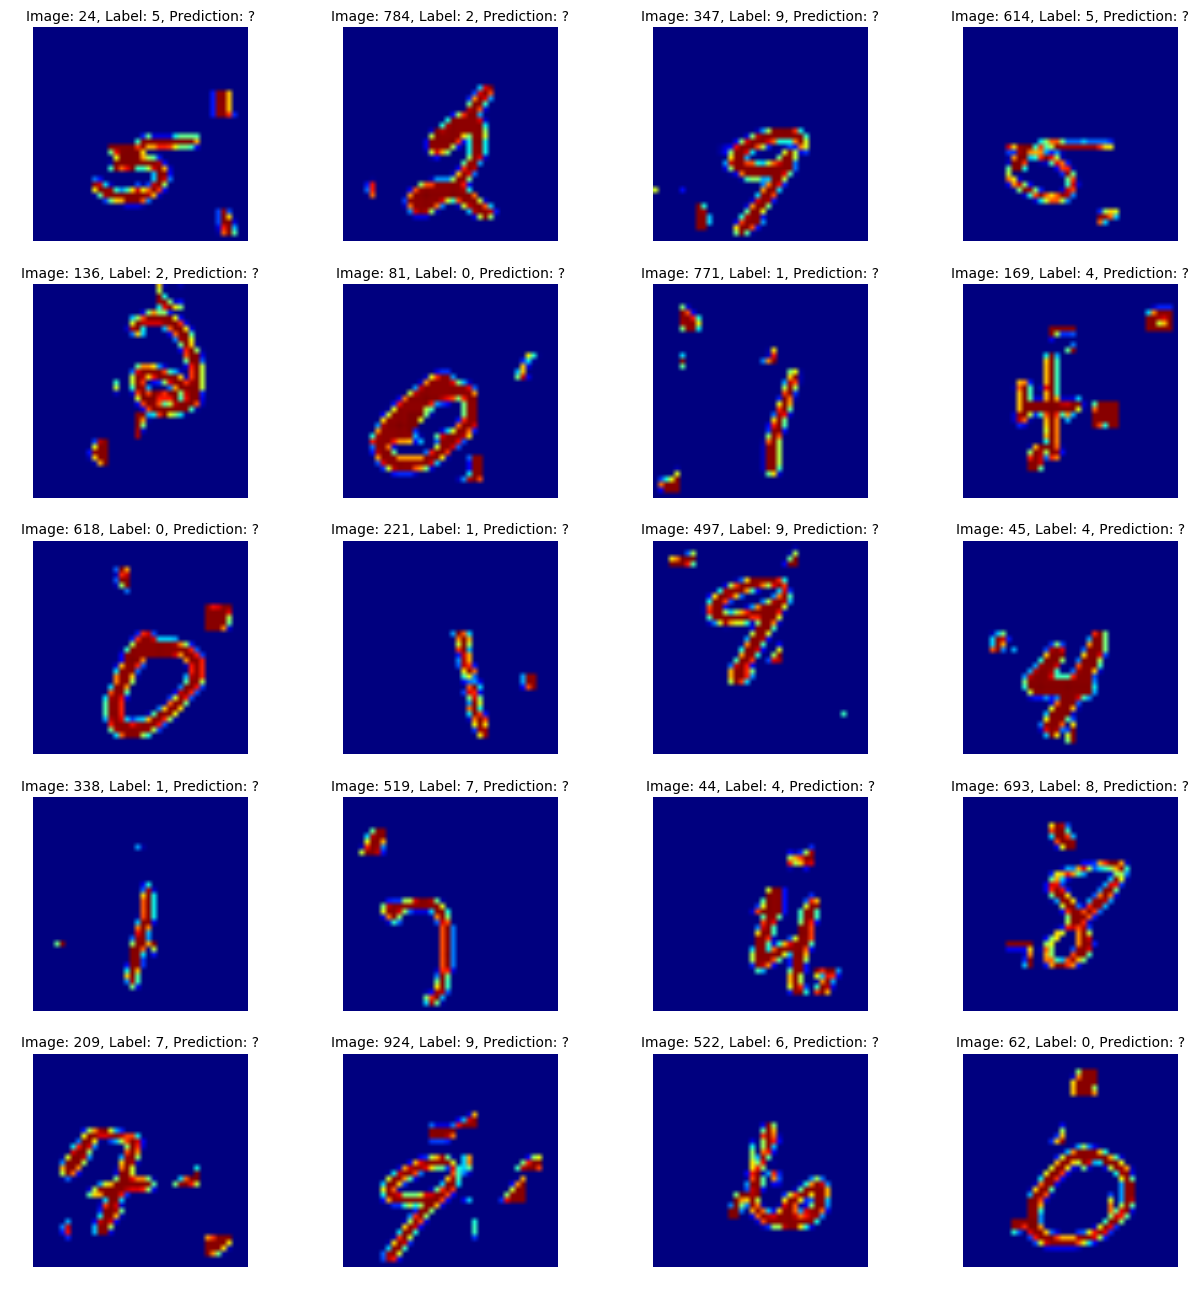

In [4]:
np.random.seed = 99
example_indices = np.random.randint(1, 1000, size=20)

ith = 0
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=.2)
for index in example_indices:
    
    plt.subplot(5, 4, ith+1)
    plt.imshow(mnist_cluttered['X_test'].reshape(1000, 40, 40)[index, ...])
    
    truth = mnist_cluttered['y_test'][index][0]

    plt.title("Image: {}, Label: {}, Prediction: ?".format(index, truth), {'fontsize': 10})
    plt.axis('off')
    ith += 1

# Graph representation of our network

In [5]:
# Placeholders for 40x40 resolution
x = tf.placeholder(tf.float32, [None, 1600])
y = tf.placeholder(tf.float32, [None, 10])

# Since x is currently [batch, height*width], we need to reshape to a
# 4-D tensor to use it in a convolutional graph.  If one component of
# `shape` is the special value -1, the size of that dimension is
# computed so that the total size remains constant.  Since we haven't
# defined the batch dimension's shape yet, we use -1 to denote this
# dimension should not change size.
x_tensor = tf.reshape(x, [-1, 40, 40, 1])

# We'll setup the two-layer localisation network to figure out the
# parameters for an affine transformation of the input
# Create variables for fully connected layer
W_fc_loc1 = weight_variable([1600, 20])
b_fc_loc1 = bias_variable([20])

W_fc_loc2 = weight_variable([20, 6])
# Use identity transformation as starting point
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32')
initial = initial.flatten()
b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')

# Define the two layer localisation network
h_fc_loc1 = tf.nn.tanh(tf.matmul(x, W_fc_loc1) + b_fc_loc1)
# We can add dropout for regularizing and to reduce overfitting like so:
keep_prob = tf.placeholder(tf.float32)
h_fc_loc1_drop = tf.nn.dropout(h_fc_loc1, keep_prob)
# Second layer
h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1_drop, W_fc_loc2) + b_fc_loc2)

# We'll create a spatial transformer module to identify discriminative
# patches
out_size = (40, 40)
h_trans = transformer(x_tensor, h_fc_loc2, out_size)

# We'll setup the first convolutional layer
# Weight matrix is [height x width x input_channels x output_channels]
filter_size = 3
n_filters_1 = 16
W_conv1 = weight_variable([filter_size, filter_size, 1, n_filters_1])

# Bias is [output_channels]
b_conv1 = bias_variable([n_filters_1])

# Now we can build a graph which does the first layer of convolution:
# we define our stride as batch x height x width x channels
# instead of pooling, we use strides of 2 and more layers
# with smaller filters.

h_conv1 = tf.nn.relu(
    tf.nn.conv2d(
        input=h_trans, filter=W_conv1, strides=[1, 2, 2, 1], padding='SAME') +
    b_conv1)

# And just like the first layer, add additional layers to create
# a deep net
n_filters_2 = 16
W_conv2 = weight_variable([filter_size, filter_size, n_filters_1, n_filters_2])
b_conv2 = bias_variable([n_filters_2])
h_conv2 = tf.nn.relu(
    tf.nn.conv2d(
        input=h_conv1, filter=W_conv2, strides=[1, 2, 2, 1], padding='SAME') +
    b_conv2)

# We'll now reshape so we can connect to a fully-connected layer:
h_conv2_flat = tf.reshape(h_conv2, [-1, 10 * 10 * n_filters_2])

# Create a fully-connected layer:
n_fc = 1024
W_fc1 = weight_variable([10 * 10 * n_filters_2, n_fc])
b_fc1 = bias_variable([n_fc])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# And finally our softmax layer:
W_fc2 = weight_variable([n_fc, 10])
b_fc2 = bias_variable([10])
y_logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define loss/eval/training functions
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=y_logits, labels=y))
opt = tf.train.AdamOptimizer()
optimizer = opt.minimize(cross_entropy)
grads = opt.compute_gradients(cross_entropy, [b_fc_loc2])

# Monitor accuracy
predictions = tf.argmax(y_logits, 1)
correct_prediction = tf.equal(tf.argmax(y_logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# We now create a new session to actually perform the initialization the
# variables:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# We'll now train in minibatches and report accuracy, loss:
iter_per_epoch = 100
n_epochs = 10
train_size = 10000

indices = np.linspace(0, 10000 - 1, iter_per_epoch)
indices = indices.astype('int')

for epoch_i in range(n_epochs):
    for iter_i in range(iter_per_epoch - 1):
        batch_xs = X_train[indices[iter_i]:indices[iter_i + 1]]
        batch_ys = Y_train[indices[iter_i]:indices[iter_i + 1]]

        if iter_i % 10 == 0:
            loss = sess.run(cross_entropy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.0})
            print('Iteration: ' + str(iter_i) + ' Loss: ' + str(loss))

        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.8})
        
    val_acc = sess.run(accuracy, feed_dict={x: X_valid, y: Y_valid, keep_prob: 1.0})

    print('{}/{} epochs, Accuracy: {:.3f}'.format(epoch_i + 1, n_epochs, val_acc))
    
test_acc, test_predictions = sess.run([accuracy, predictions], feed_dict={x: X_test, y: Y_test, keep_prob: 1.0})
#     theta = sess.run(h_fc_loc2, feed_dict={x: batch_xs, keep_prob: 1.0})
#     print(theta[0])

Iteration: 0 Loss: 2.30328
Iteration: 10 Loss: 2.29888
Iteration: 20 Loss: 2.29573
Iteration: 30 Loss: 2.30278
Iteration: 40 Loss: 2.30159
Iteration: 50 Loss: 2.29684
Iteration: 60 Loss: 2.294
Iteration: 70 Loss: 2.26224
Iteration: 80 Loss: 2.23668
Iteration: 90 Loss: 2.17271
1/10 epochs, Accuracy: 0.214
Iteration: 0 Loss: 2.11102
Iteration: 10 Loss: 1.98436
Iteration: 20 Loss: 1.70514
Iteration: 30 Loss: 1.46261
Iteration: 40 Loss: 1.23572
Iteration: 50 Loss: 1.25274
Iteration: 60 Loss: 1.0751
Iteration: 70 Loss: 1.10993
Iteration: 80 Loss: 1.18623
Iteration: 90 Loss: 0.850672
2/10 epochs, Accuracy: 0.698
Iteration: 0 Loss: 1.03244
Iteration: 10 Loss: 0.963616
Iteration: 20 Loss: 0.823427
Iteration: 30 Loss: 0.811916
Iteration: 40 Loss: 0.676934
Iteration: 50 Loss: 0.909632
Iteration: 60 Loss: 0.721829
Iteration: 70 Loss: 0.820445
Iteration: 80 Loss: 0.832004
Iteration: 90 Loss: 0.656289
3/10 epochs, Accuracy: 0.760
Iteration: 0 Loss: 0.75579
Iteration: 10 Loss: 0.764717
Iteration: 20

# Plot examples from earlier

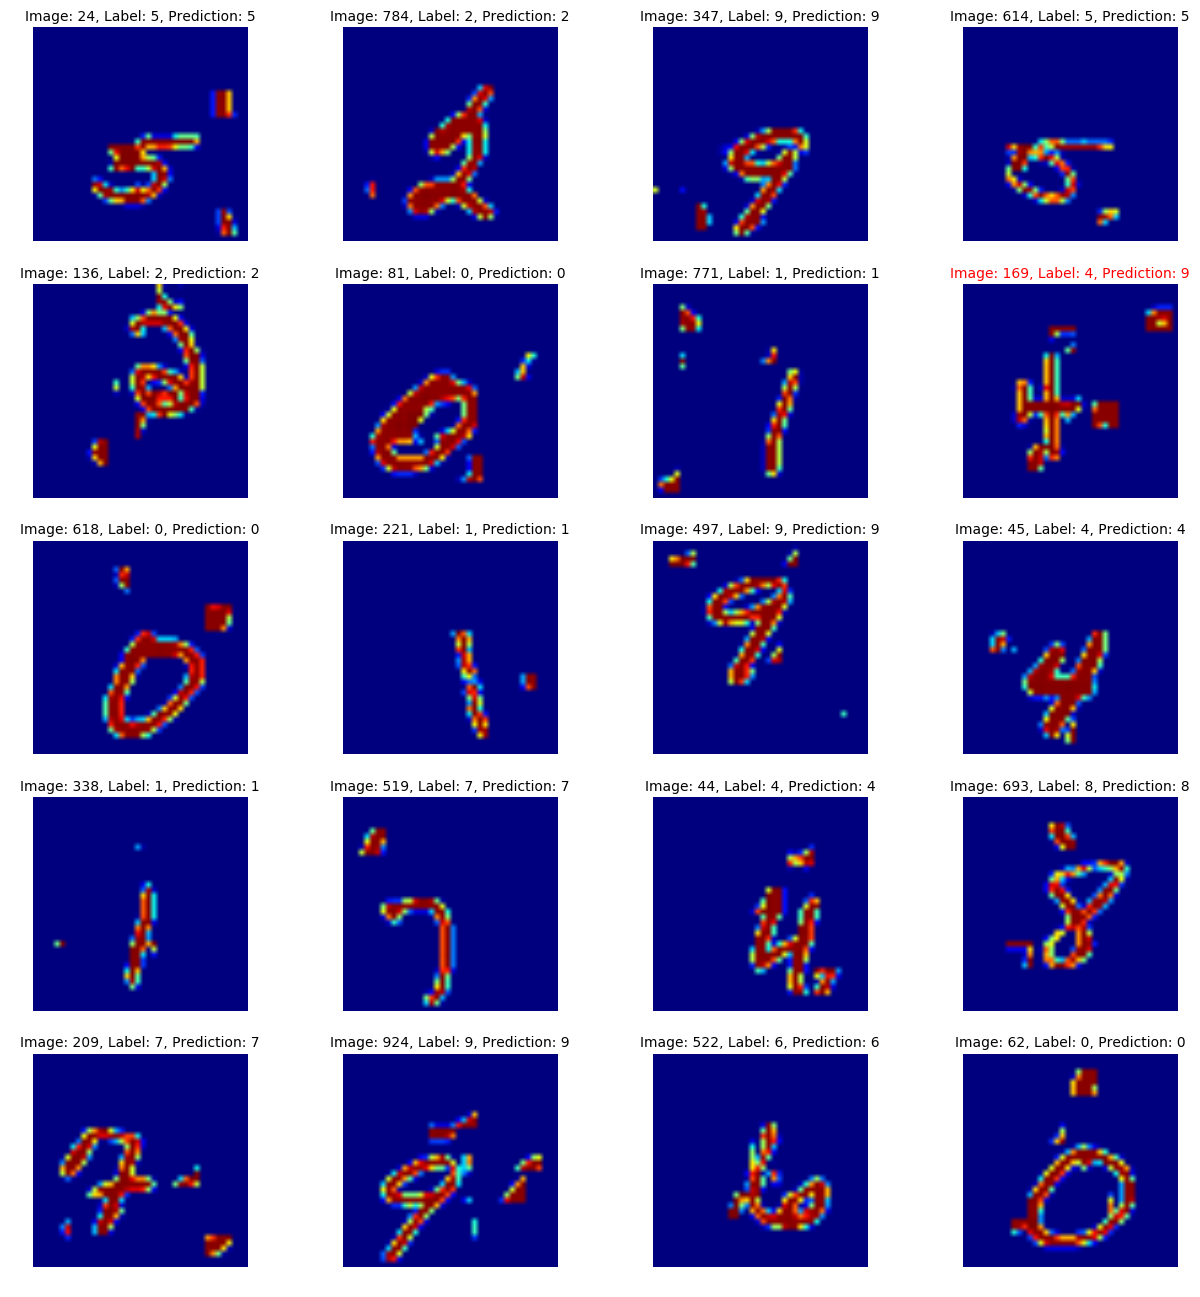

In [6]:
ith = 0
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=.2)
for index in example_indices:
    
    plt.subplot(5, 4, ith+1)
    plt.imshow(mnist_cluttered['X_test'].reshape(1000, 40, 40)[index, ...])
    
    truth = mnist_cluttered['y_test'][index][0]
    pred = test_predictions[index]

    if truth == pred:
        label_color = 'black'
    else:
        label_color = 'red'

    plt.title("Image: {}, Label: {}, Prediction: {}".format(index, truth, pred), {'fontsize': 10},  color=label_color)
    plt.axis('off')
    ith += 1